<a href="https://colab.research.google.com/github/olegkleiman/udemy_nlp/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext tensorboard


In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
#from tensorflow.callbacks import Callbacks

In [4]:
dataset, dataset_info = tfds.load('malaria',
          with_info=True,
          as_supervised=True,
          shuffle_files=True,
          split=['train'])

In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO* DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO* DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

The dataset is split into training, validation, and testing sets with ratios of 80%, 10%, and 10%, respectively.

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [7]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

Data vizualization

(-0.5, 153.5, 132.5, -0.5)

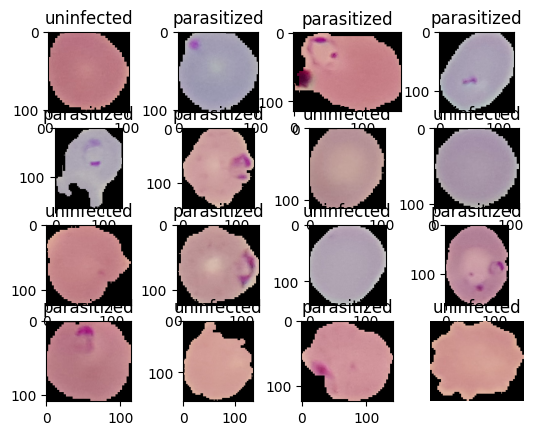

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
plt.axis('off')

Data Preprocessing

In [9]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
train_dataset

In [11]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(133, 154, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32
#train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Model Creation

In [16]:
# lenet_model = tf.keras.Sequential([
#     InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
#     Conv2D(filters=6, kernel_size=6, strides=1, padding='valid', activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size=2, strides=2),

#     Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size=2, strides=2),
#     Flatten(),
#     Dense(100, activation='relu'),
#     BatchNormalization(),

#     Dense(10, activation='relu'),
#     BatchNormalization(),

#     Dense(1, activation='sigmoid'),
# ])

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=6, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),



])

lenet_model.summary(())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 6)       654       
                                                                 
 batch_normalization (BatchN  (None, 219, 219, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 107, 107, 16)     64        
 hNormalization)                                                 
                                                        

In [17]:
y_true = [0,1,0,0]
y_pred = [0.6,0.51,0.94,1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [18]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics= ['accuracy'])

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = lenet_model.fit(train_dataset,
                          validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
  8/689 [..............................] - ETA: 25:40 - loss: 0.7892 - accuracy: 0.5430